In [ ]:
"""
This replication will add the tuning of parameters with Cross-Validation
Steps that are identical to the previous replication are grouped together
"""

In [1]:
# Basic packages to manipulate data
import numpy as np
import pandas as pd

# Read data
# file 'fraud_machinelearning.csv' is supposedly stored under the current directory
# data is a type of DataFrame, and contains all the observations and features
data = pd.read_csv("./fraud_machinelearning.csv")

# Only 24 features were used in the paper to make the prediction
# We create a list that contains the names of these 24 features, of identifier, and of label/fraud
first_col = ['GVKEY', 'FYEAR', 'AAER_fraud', 'CHE', 'RECT', 'INVT', 'STI', 'PPEGT', 'IVAO', 'AT', 
             'DLC', 'TXP', 'LCT', 'DLTT', 'LT', 'SEQ', 'PSTK', 'RE', 'SALE', 'COGS',
             'DP', 'XINT', 'TXT', 'IB', 'NI', 'PRCC_F', 'CSHO']

# data_first is a new DataFrame that contains only variables that we will use
data_first  = data[first_col].copy(deep=True)

# In this replication, we will use observations between 1991 and 2001 as training set
# "FYEAR" is the identifier to select the observations
train_91_01 = data_first[data_first.FYEAR > 1990]
train_91_01 = train_91_01[train_91_01.FYEAR < 2002]

# We will use observations in 2003 as test set
test_03 = data_first[data_first.FYEAR == 2003]

# Create a new list that contains only the names of the 24 features
first_col_features = []
for i in first_col:
    first_col_features.append(i)
first_col_features.remove("GVKEY")
first_col_features.remove("FYEAR")
first_col_features.remove("AAER_fraud")

# Here the new part starts
from sklearn.preprocessing import Imputer

# In this example, the observations that we used to impute missing values are the ones
# that are in the same year(FYEAR)
# We take a simple approach: replace missing value with the most frequent value of the feature

# Impute training set
imp_lis_freq = []
for i in train_91_01.FYEAR.unique():
    imr_train_freq = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    imr_train_freq = imr_train_freq.fit(train_91_01[train_91_01.FYEAR == i])
    imputed_train_freq = imr_train_freq.transform(train_91_01[train_91_01.FYEAR == i].values)
    imp_lis_freq.append(imputed_train_freq)
    
imputed_train_freq = pd.DataFrame(imp_lis_freq[0])
imputed_train_freq.columns = train_91_01.columns

for i in range(1, 11):
    imputed_tmp_freq = pd.DataFrame(imp_lis_freq[i])
    imputed_tmp_freq.columns = train_91_01.columns
    imputed_train_freq = imputed_train_freq.append(imputed_tmp_freq)

# Impute test set
imr_test_freq = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imr_test_freq = imr_test_freq.fit(test_03)
imputed_test_freq = imr_test_freq.transform(test_03.values)
imputed_test_freq = pd.DataFrame(imputed_test_freq)
imputed_test_freq.columns = test_03.columns

# Separate train and test set into feature and label
fraud_freq_91_01 = imputed_train_freq.AAER_fraud
feature_freq_91_01 = imputed_train_freq[first_col_features]

fraud_freq_03 = imputed_test_freq.AAER_fraud
feature_freq_03 = imputed_test_freq[first_col_features]

# Use Random Forest from Scikit-learn as classifier
# The reason to choose Random Forst is because its implementation in Scikit-learn
# has the option to utilize multi-core CPU processing
from sklearn.ensemble import RandomForestClassifier

# Use area under the Receiver Operating Characteristics (ROC) curve (AUC) 
# to evaluate the performance
from sklearn.metrics import roc_auc_score

In [2]:
# Import StratifiedKFold from Scikit-Learning. 
# Depend on the version, the module may be moved to section other than "cross_validation"
# StratifiedKFold provides train/test indices to split data in train/test sets
# We choose 10 folds cross-validation
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=fraud_freq_91_01, n_folds=10, random_state=0)

/home/chao/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# There are many parameters that we can tune in Random Forest Classifier
# In this demo, we choose "max_depth": The maximum depth of the tree

# The empty list that will hold the scores of different parameter value
valid_scores = []
test_scores = []

# The set of "max_depth" values that we want to try
param_range = [1, 5, 10, 15, 20]

for i in param_range:
    valid_scores_tmp = []
    test_scores_tmp = []
    for k, (train, test) in enumerate(kfold):
        clf_RF = RandomForestClassifier(n_estimators=500, n_jobs=4, max_depth=i)
        clf_RF.fit(feature_freq_91_01.iloc[train], fraud_freq_91_01.iloc[train])
        valid_score = roc_auc_score(fraud_freq_91_01.iloc[test], \
                                    clf_RF.predict_proba(feature_freq_91_01.iloc[test])[:,1])
        valid_scores_tmp.append(valid_score)
        test_score = roc_auc_score(fraud_freq_03, clf_RF.predict_proba(feature_freq_03)[:,1])
        test_scores_tmp.append(test_score)
    valid_scores.append((np.mean(valid_scores_tmp), np.std(valid_scores_tmp)))
    test_scores.append((np.mean(test_scores_tmp), np.std(test_scores_tmp)))

In [4]:
# Calculate the mean and standard deviation of performance scores on valid and test set
valid_mean = []
valid_std = []
for i in range(len(param_range)):
    valid_mean.append(valid_scores[i][0])
    valid_std.append(valid_scores[i][1])
valid_mean = np.array(valid_mean)
valid_std = np.array(valid_std)

test_mean = []
test_std = []
for i in range(len(param_range)):
    test_mean.append(test_scores[i][0])
    test_std.append(test_scores[i][1])
test_mean = np.array(test_mean)
test_std = np.array(test_std)

(0.65, 0.85)

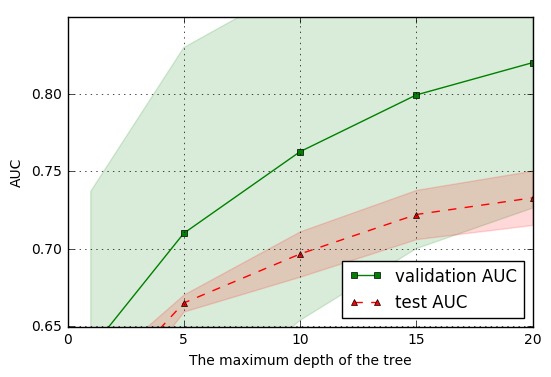

In [5]:
# Plot the result
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(param_range, valid_mean, color='green', marker='s',
         markersize=5, label='validation AUC')
plt.fill_between(param_range, valid_mean + valid_std,
                 valid_mean - valid_std, alpha=0.15, color='green')

plt.plot(param_range, test_mean, color='red', marker='^',
         markersize=5, label='test AUC', linestyle='--')
plt.fill_between(param_range, test_mean + test_std,
                 test_mean - test_std, alpha=0.15, color='red')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel('The maximum depth of the tree')
plt.ylabel('AUC')
plt.ylim([0.65, 0.85])